<a href="https://colab.research.google.com/github/alexgirmag/Predicting-Emergency-Department-Mortality-Risk-Using-Machine-Learning-Algorithms/blob/main/RF_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries and pre-prosessed data

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

# Scikit-learn: Models & Multioutput
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Scikit-learn: Preprocessing & Composition
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Scikit-learn: Model Selection & Metrics
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.experimental import enable_halving_search_cv  # Required for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Imbalanced-learn: Pipeline & Sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

## Importing pre-prosessed data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path1 =  "/content/drive/MyDrive/Splited_X_train.xlsx"

In [4]:
file_path2 =  "/content/drive/MyDrive/Splited_X_test.xlsx"

In [5]:
file_path3 =  "/content/drive/MyDrive/Splited_y_train.xlsx"

In [6]:
file_path4 =  "/content/drive/MyDrive/Splited_y_test.xlsx"

In [7]:
X_train = pd.read_excel(file_path1)

In [8]:
X_test = pd.read_excel(file_path2)

In [9]:
y_train = pd.read_excel(file_path3)

In [10]:
y_test = pd.read_excel(file_path4)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7063, 23)
(1766, 23)
(7063, 1)
(1766, 1)


In [12]:
print(X_train.columns)

Index(['Metabolic_Case', 'Oncologic_Case', 'Age_group',
       'Mean Arterial Pressure', 'Triage color', 'Respiratory Rate',
       'PCA_Oxygen Delivery Index', 'White Blood Cells', 'Basophils',
       'Eosinophils', 'Platelets', 'Heart Rate', 'Gender_Male',
       'Visit type_repeat', 'Cardiovascular_Case', 'Gastrointestinal_Case',
       'Mean Corpuscular Volume', 'Red Cell Distribution Width',
       'Triage Waiting Time', 'Infectious_Case', 'Case Category_medical',
       'Case Category_surgical', 'Case Category_trauma'],
      dtype='object')


In [13]:
#Class distribution
print("Class distribution:", np.unique(y_train, return_counts=True))

Class distribution: (array([0, 1]), array([6323,  740]))


# Modularize Evaluation and Plotting

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
import numpy as np

def evaluate_model_performance(y_true, y_pred, y_proba, model_name="Model"):
    """
    Evaluates a classification model and generates various plots.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model for display in plots and reports.
    """

    print(f"\n{'='*20} Evaluation for {model_name} {'='*20}")

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['alive (0)', 'Died (1)']))

    # 2. Confusion Matrix with Specificity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # 3. AUC-ROC Curve
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba)
    roc_auc_plot = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc_plot:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall/Sensitivity)')
    plt.title(f'{model_name} - Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Precision-Recall Curve with Optimal Threshold
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # Avoid division by zero

    # Find the optimal threshold (max F1-score)
    # Note: thresholds_pr has one less element than precision/recall, so we align indices
    optimal_idx = np.argmax(f1_scores[:-1]) # Exclude the last element of f1_scores for threshold alignment
    optimal_threshold = thresholds_pr[optimal_idx]
    optimal_precision = precision[optimal_idx]
    optimal_recall = recall[optimal_idx]

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.scatter(optimal_recall, optimal_precision, color='red', s=100,
                label=f'Optimal Point (Threshold = {optimal_threshold:.2f})\nPrecision = {optimal_precision:.2f}, Recall = {optimal_recall:.2f}')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title(f'{model_name} - Precision-Recall Curve with Optimal Threshold')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # 5. Classification Report and Confusion Matrix at Optimal Threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print(f"\nClassification Report at Optimal Threshold ({optimal_threshold:.2f}):")
    print(classification_report(y_true, y_pred_optimal, target_names=['Alive', 'Died']))

    cm_optimal = confusion_matrix(y_true, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
    specificity_optimal = tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) != 0 else 0
    print(f"Confusion Matrix at Optimal Threshold:\n{cm_optimal}")
    print(f"Specificity (True Negative Rate) at Optimal Threshold: {specificity_optimal:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f"{model_name} - Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
    plt.show()
    print(f"\n{'='*60}")


In [15]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

In [16]:
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

# Train model Before Balancing

##Before Balancing And Tuning

**Training**

In [17]:

model_1 = RandomForestClassifier(
    n_estimators=100,
    random_state=123,
    n_jobs=-1
)

In [18]:

model_1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_jobs=-1, random_state=123)

**Prediction**

In [19]:

y_pred1 = model_1.predict(X_test)
y_proba1 = model_1.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_1 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.99      0.97      1581
    Died (1)       0.85      0.51      0.64       185

    accuracy                           0.94      1766
   macro avg       0.90      0.75      0.80      1766
weighted avg       0.94      0.94      0.93      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9892


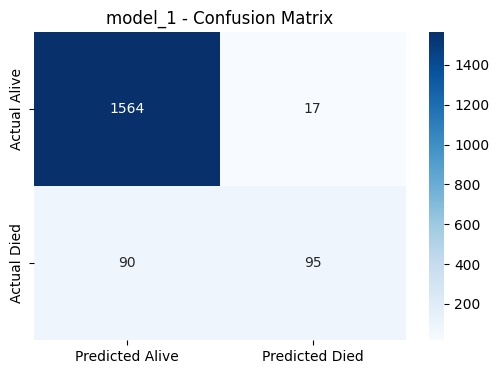


ROC-AUC Score: 0.7812


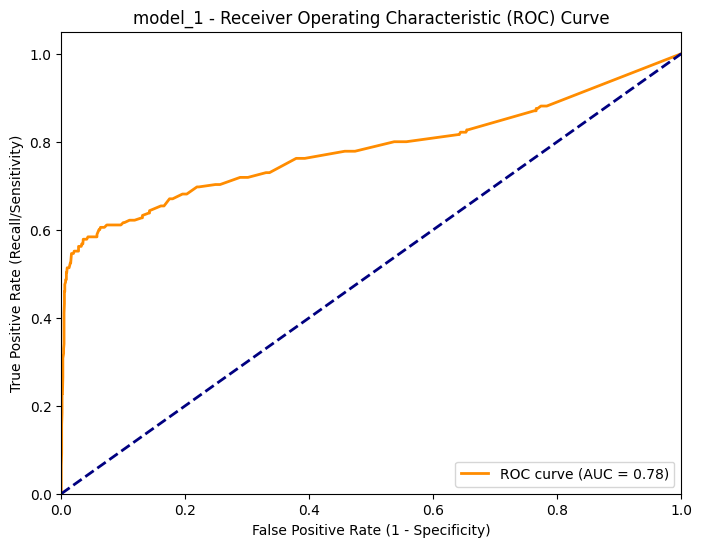

PR-AUC Score: 0.6192


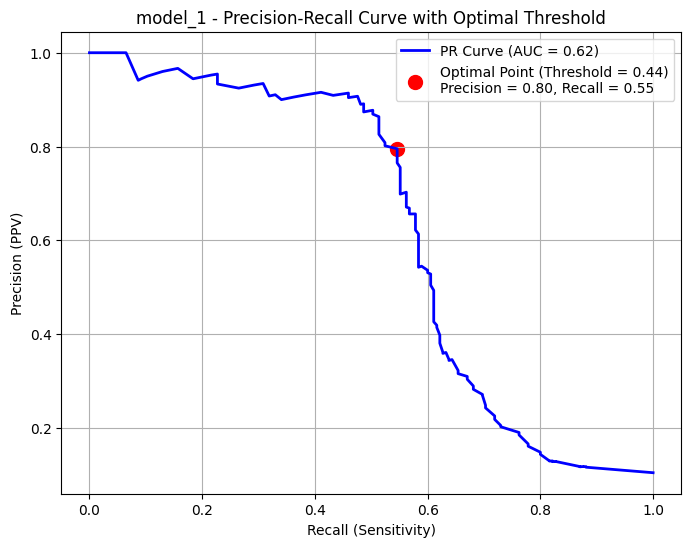


Classification Report at Optimal Threshold (0.44):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.97      1581
        Died       0.80      0.55      0.65       185

    accuracy                           0.94      1766
   macro avg       0.87      0.76      0.81      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1555   26]
 [  84  101]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9836


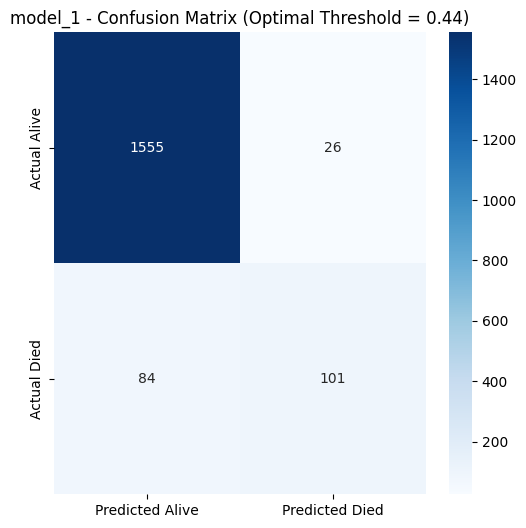

In [20]:
evaluate_model_performance(y_test, y_pred1, y_proba1, model_name="model_1")

## Hyperparameter Tuning: RandomizedSearchCV

**Training**

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5],
    'class_weight': ['balanced', {1: 2, 0: 1}]
}

In [ ]:

rf_rs = RandomizedSearchCV(
    estimator= model_1,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=123
)

In [ ]:
rf_rs.fit(X_train, y_train)
print("Best params:", rf_rs.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20, 'class_weight': {1: 2, 0: 1}}


In [ ]:
print("Best parameters found: ", rf_rs.best_params_)
print("Best F1 score: ", rf_rs.best_score_)

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20, 'class_weight': {1: 2, 0: 1}}
Best F1 score:  0.6936374679751118


In [ ]:
best_rf_rs = rf_rs.best_estimator_
best_rf_rs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=20,
                       max_features=0.5, min_samples_split=5, n_estimators=300,
                       n_jobs=-1, random_state=123)

**Prediction**

In [ ]:

y_pred2 = best_rf_rs.predict(X_test)
y_proba2 = best_rf_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_2 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.99      0.97      1581
    Died (1)       0.88      0.54      0.67       185

    accuracy                           0.94      1766
   macro avg       0.92      0.76      0.82      1766
weighted avg       0.94      0.94      0.94      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9918


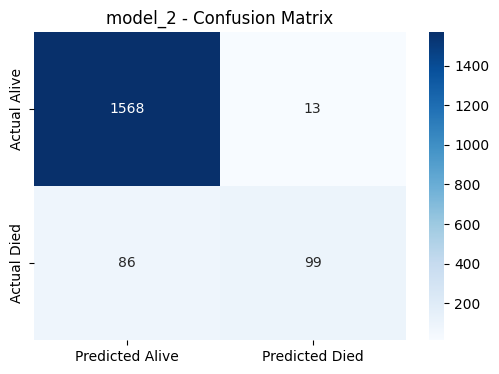


ROC-AUC Score: 0.7985


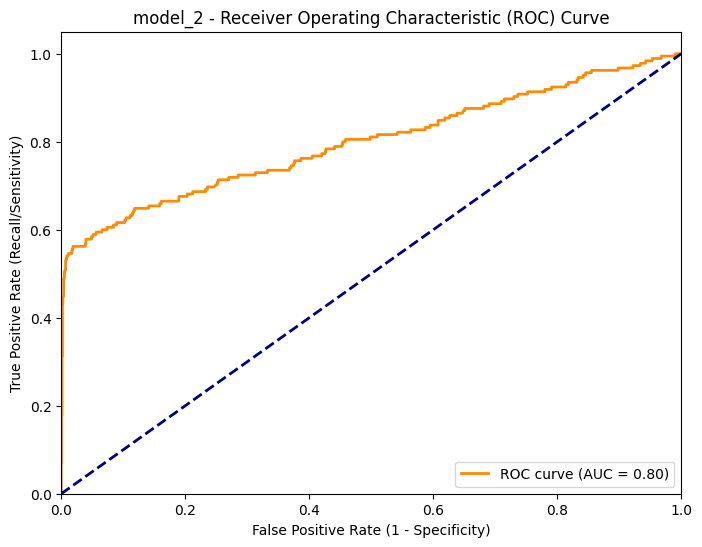

PR-AUC Score: 0.6370


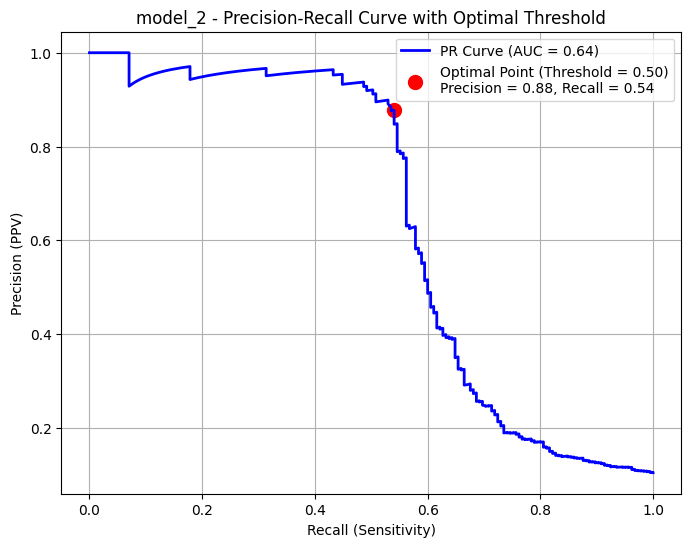


Classification Report at Optimal Threshold (0.50):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.88      0.54      0.67       185

    accuracy                           0.94      1766
   macro avg       0.91      0.77      0.82      1766
weighted avg       0.94      0.94      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1567   14]
 [  85  100]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9911


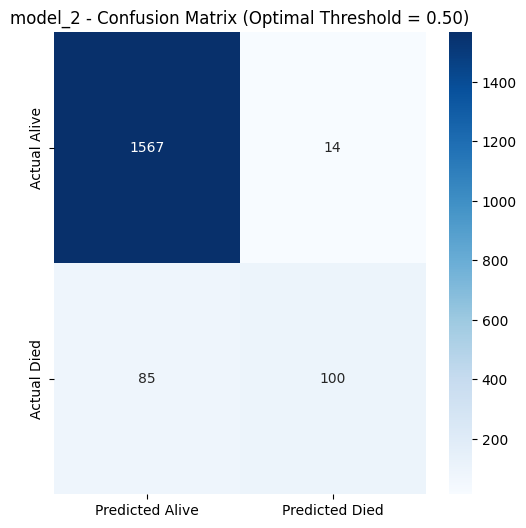

In [ ]:
evaluate_model_performance(y_test, y_pred2, y_proba2, model_name="model_2")

## Hyperparameter Tuning: Grid Search (GS)

**Training**

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 0.5]
}

In [ ]:

rf_gs = GridSearchCV(
    estimator=model_1,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1
)

In [ ]:
rf_gs.fit(X_train, y_train)
print(f"Best params: {rf_gs.best_params_}\nBest score: {rf_gs.best_score_:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.6871


In [ ]:

print("Best parameters found: ", rf_gs.best_params_)
print("Best F1 score: ", rf_gs.best_score_)

Best parameters found:  {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score:  0.6871114996114996


In [ ]:
best_rf_gs = rf_gs.best_estimator_
best_rf_gs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=123)

**Prediction**

In [ ]:

y_pred3 = best_rf_gs.predict(X_test)
y_proba3 = best_rf_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_3 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.98      0.97      1581
    Died (1)       0.79      0.55      0.65       185

    accuracy                           0.94      1766
   macro avg       0.87      0.77      0.81      1766
weighted avg       0.93      0.94      0.93      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9829


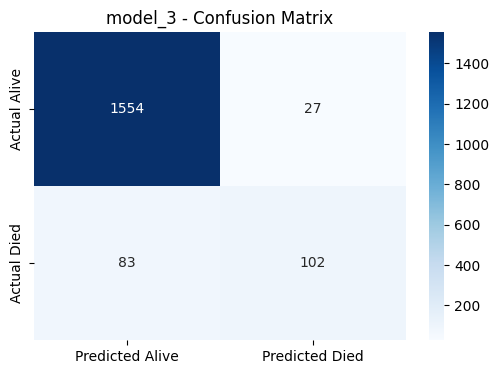


ROC-AUC Score: 0.8098


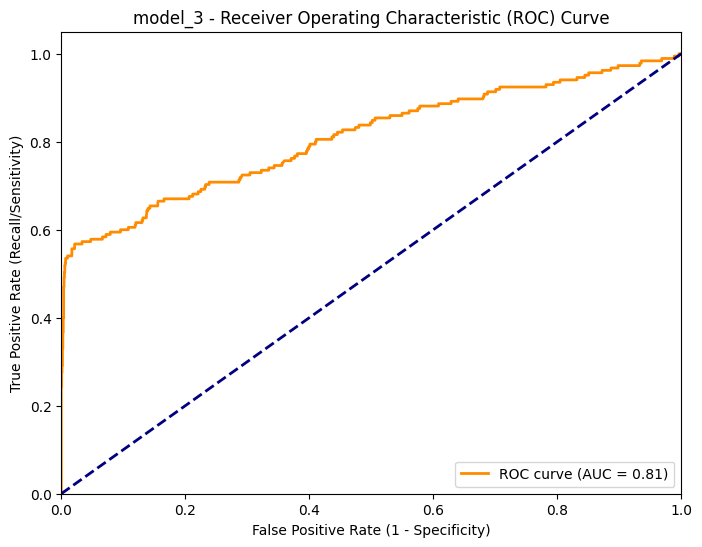

PR-AUC Score: 0.6412


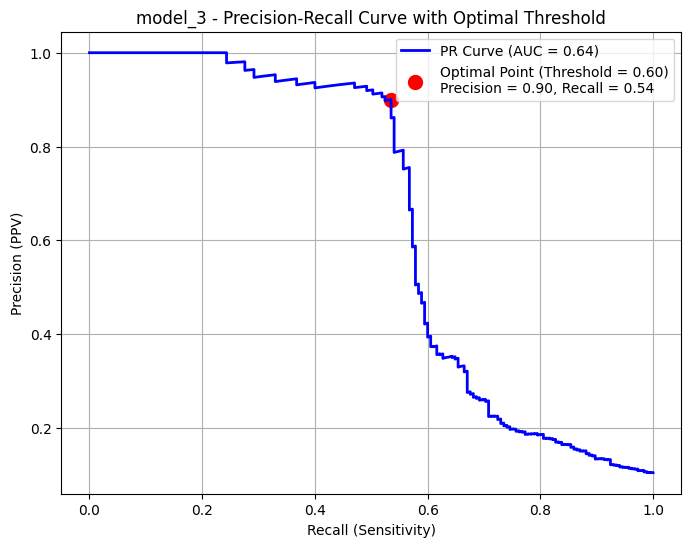


Classification Report at Optimal Threshold (0.60):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.90      0.54      0.67       185

    accuracy                           0.95      1766
   macro avg       0.92      0.76      0.82      1766
weighted avg       0.94      0.95      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1570   11]
 [  86   99]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9930


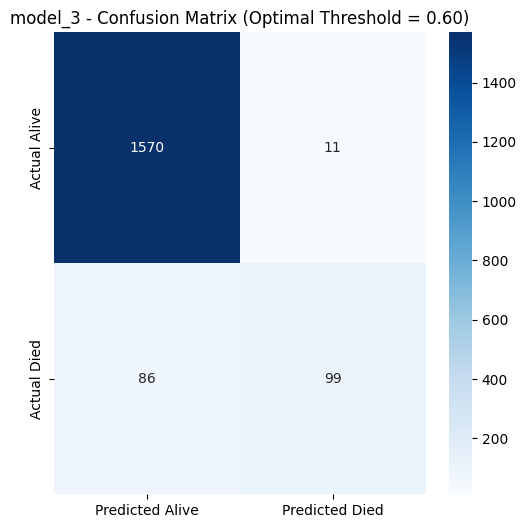

In [ ]:
evaluate_model_performance(y_test, y_pred3, y_proba3, model_name="model_3")

# Train the model after Balancing using SMOTE

##SMOT Only

**Training**

In [ ]:

rf_os = make_pipeline(
    SMOTE(random_state=123),
    model_1
)

In [ ]:

rf_os.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=123))])

**Prediction**

In [ ]:

y_os_pred1 = rf_os.predict(X_test)
y_os_proba1 = rf_os.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_4 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.94      0.94      1581
    Died (1)       0.50      0.55      0.52       185

    accuracy                           0.90      1766
   macro avg       0.72      0.74      0.73      1766
weighted avg       0.90      0.90      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9361


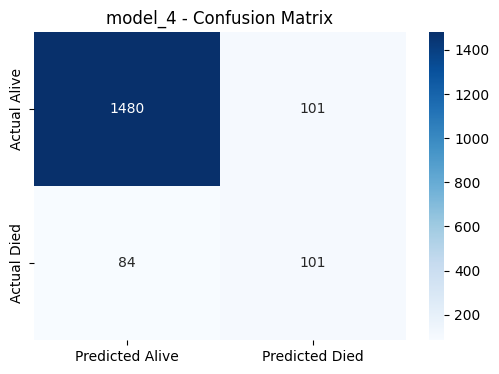


ROC-AUC Score: 0.7774


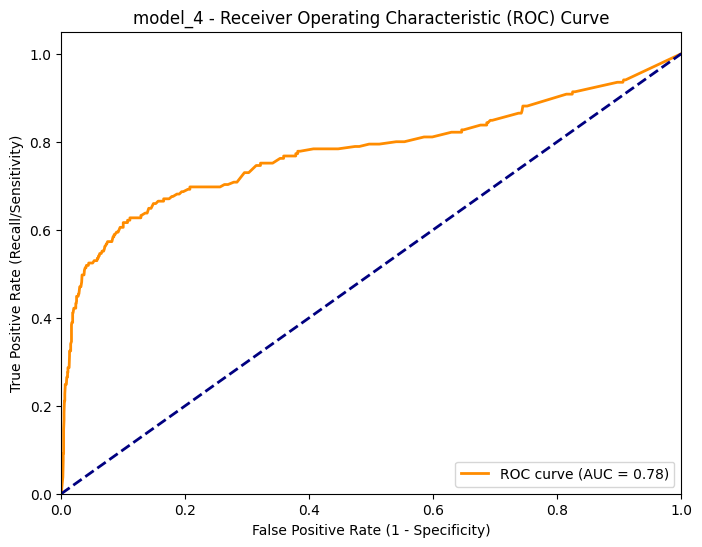

PR-AUC Score: 0.5035


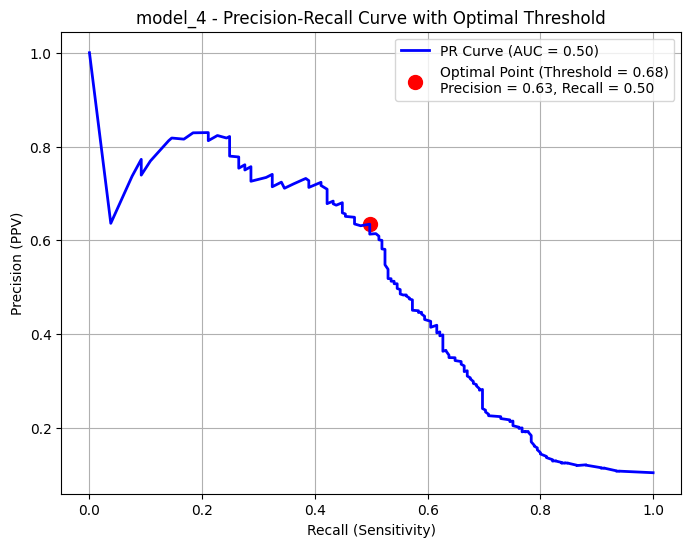


Classification Report at Optimal Threshold (0.68):
              precision    recall  f1-score   support

       Alive       0.94      0.97      0.95      1581
        Died       0.63      0.50      0.56       185

    accuracy                           0.92      1766
   macro avg       0.79      0.73      0.76      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1528   53]
 [  93   92]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9665


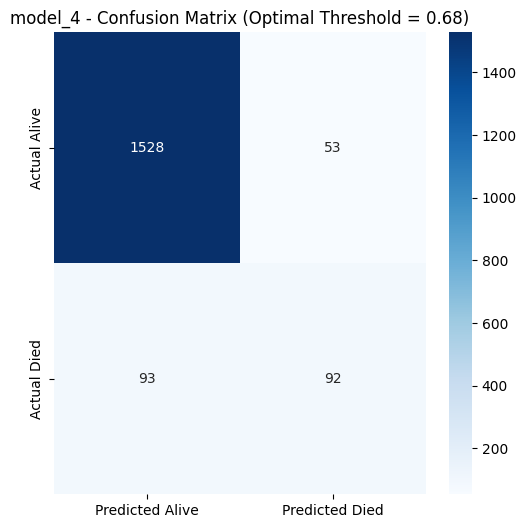

In [ ]:
evaluate_model_performance(y_test, y_os_pred1, y_os_proba1, model_name="model_4")

## SMOTE + RandomizedSearchCV

**Training**

In [ ]:
param_dist = {
    'randomforestclassifier__n_estimators': randint(50, 300),
    'randomforestclassifier__max_depth': [None, 6, 10, 15, 20],
    'randomforestclassifier__min_samples_split': randint(2, 20),
    'randomforestclassifier__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [ ]:

rf_os_rs = RandomizedSearchCV(
    estimator=rf_os,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=123
)

In [ ]:

rf_os_rs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=123))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__class_weight': [None,
                                                                                 'balanced',
                                                                                 'balanced_subsample'],
                                        'randomfor...
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bed2fc1a840>,
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bed2fc19310>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bed2fbf69f0>},
                   random_state=123, scoring='f1')

In [ ]:

print("Best parameters found: ", rf_os_rs.best_params_)
print("Best F1 score: ", rf_os_rs.best_score_)

Best parameters found:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 7, 'randomforestclassifier__n_estimators': 272}
Best F1 score:  0.5877323753014443


In [ ]:
best_rf_os_rs = rf_os_rs.best_estimator_
best_rf_os_rs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=7, n_estimators=272,
                                        n_jobs=-1, random_state=123))])

**Prediction**

In [ ]:

y_os_pred2 = best_rf_os_rs.predict(X_test)
y_os_proba2 = best_rf_os_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_5 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.95      0.95      1581
    Died (1)       0.57      0.57      0.57       185

    accuracy                           0.91      1766
   macro avg       0.76      0.76      0.76      1766
weighted avg       0.91      0.91      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9500


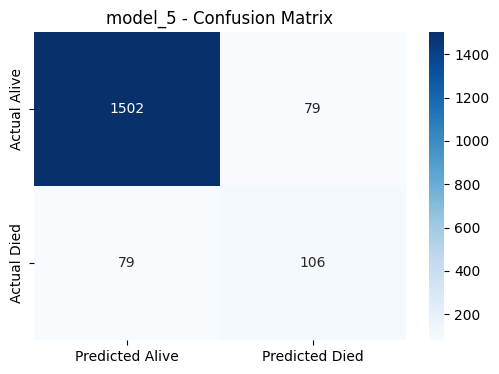


ROC-AUC Score: 0.8012


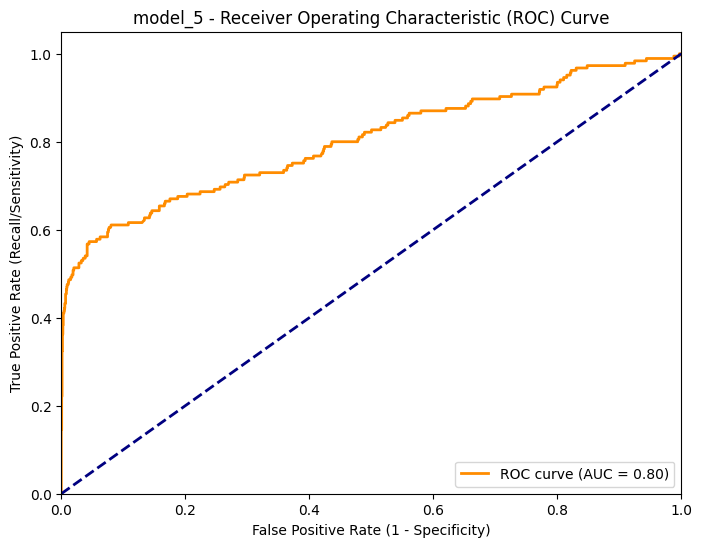

PR-AUC Score: 0.6173


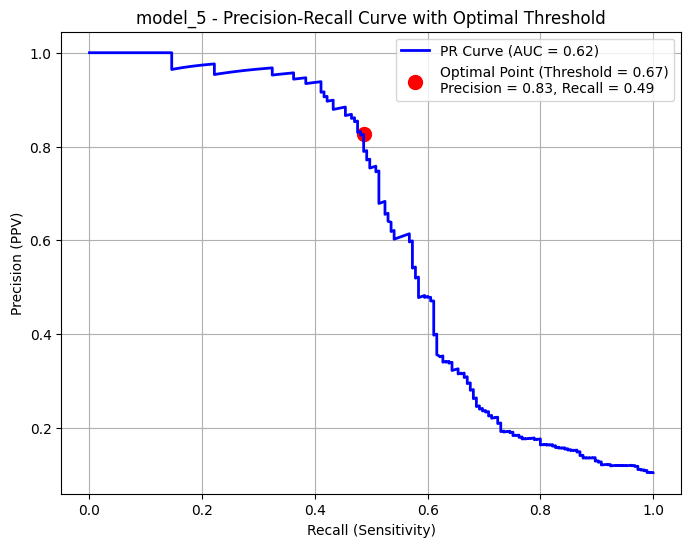


Classification Report at Optimal Threshold (0.67):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.96      1581
        Died       0.83      0.49      0.61       185

    accuracy                           0.94      1766
   macro avg       0.88      0.74      0.79      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1562   19]
 [  95   90]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9880


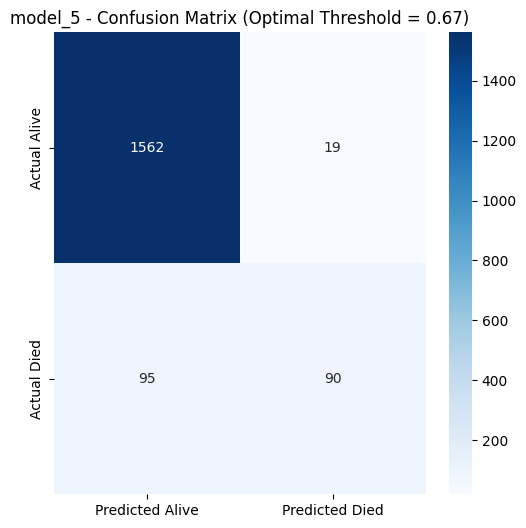

In [ ]:
evaluate_model_performance(y_test, y_os_pred2, y_os_proba2, model_name="model_5")

## SMOTE + GridSearchCV

**Training**

In [ ]:
param_grid = {
    'smote__k_neighbors': [3, 5, 7],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 6, 10, 15],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__max_features': ['sqrt', 0.6, 0.8]
}

In [ ]:
# Configure GridSearch
rf_os_gs = GridSearchCV(
    estimator=rf_os,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
# Usage:
rf_os_gs.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=123))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 6, 10, 15],
                         'randomforestclassifier__max_features': ['sqrt', 0.6,
                                                                  0.8],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100, 200,
                                                                  300],
                         'smote__k_neighbors': [3, 5, 7]},
             scoring='f1', verbose=1)

In [ ]:

print("\nBest Params:", rf_os_gs.best_params_)
print("Best F1 Score (CV):", rf_os_gs.best_score_)


Best Params: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200, 'smote__k_neighbors': 3}
Best F1 Score (CV): 0.6190710047711736


In [ ]:
best_rf_os_gs = rf_os_gs.best_estimator_
best_rf_os_gs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(k_neighbors=3, random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=123))])

**Prediction**

In [ ]:
# Generate predictions and probabilities
y_os_pred3 = best_rf_os_gs.predict(X_test)
y_os_proba3 = best_rf_os_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_6 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.97      0.96      1581
    Died (1)       0.65      0.54      0.59       185

    accuracy                           0.92      1766
   macro avg       0.80      0.75      0.77      1766
weighted avg       0.92      0.92      0.92      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9658


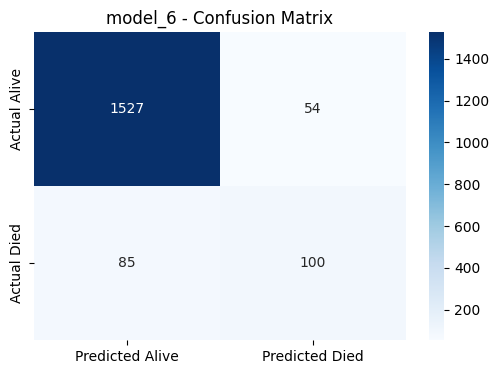


ROC-AUC Score: 0.8063


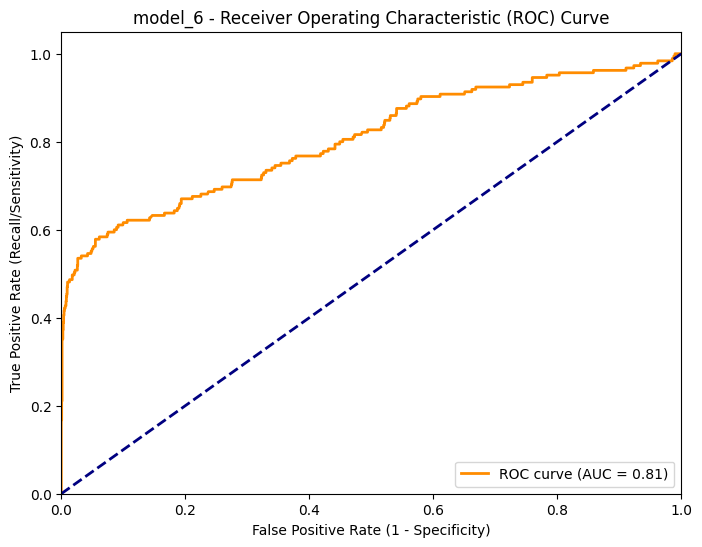

PR-AUC Score: 0.6153


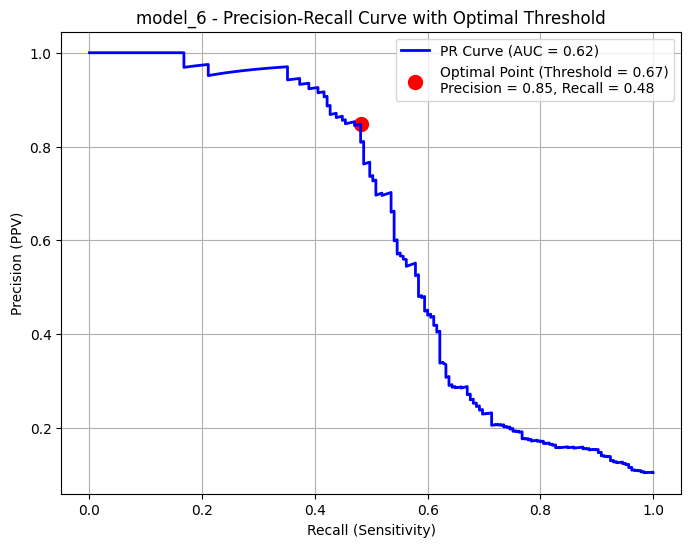


Classification Report at Optimal Threshold (0.67):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.97      1581
        Died       0.85      0.48      0.61       185

    accuracy                           0.94      1766
   macro avg       0.89      0.74      0.79      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1565   16]
 [  96   89]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9899


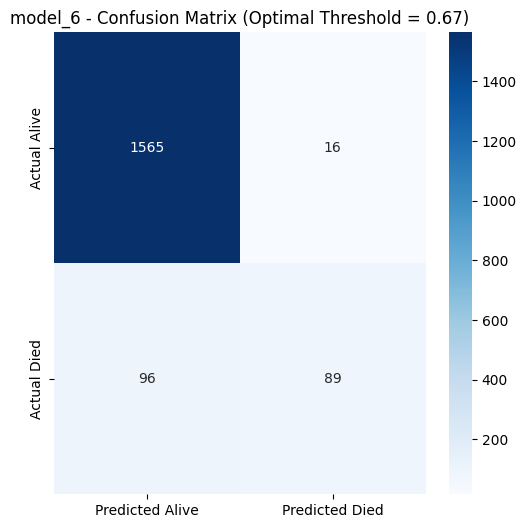

In [ ]:
evaluate_model_performance(y_test, y_os_pred3, y_os_proba3, model_name="model_6")

# Train the model after Balancing using undersampling

##UnderSampler Only

**Training**

In [ ]:

rf_us = make_pipeline(
    RandomUnderSampler(random_state=123),
    model_1
)

In [ ]:

rf_us.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=123))])

**Prediction**

In [ ]:

y_us_pred1 = rf_us.predict(X_test)
y_us_proba1 = rf_us.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_7 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.96      0.86      0.90      1581
    Died (1)       0.35      0.66      0.46       185

    accuracy                           0.84      1766
   macro avg       0.65      0.76      0.68      1766
weighted avg       0.89      0.84      0.86      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8552


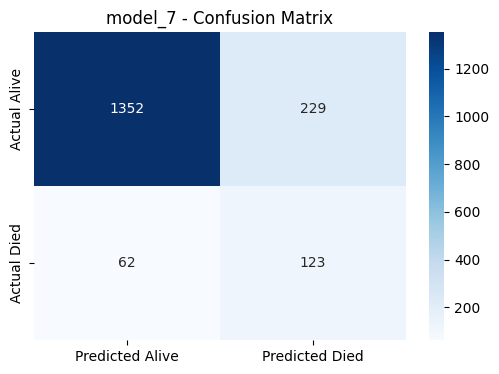


ROC-AUC Score: 0.8044


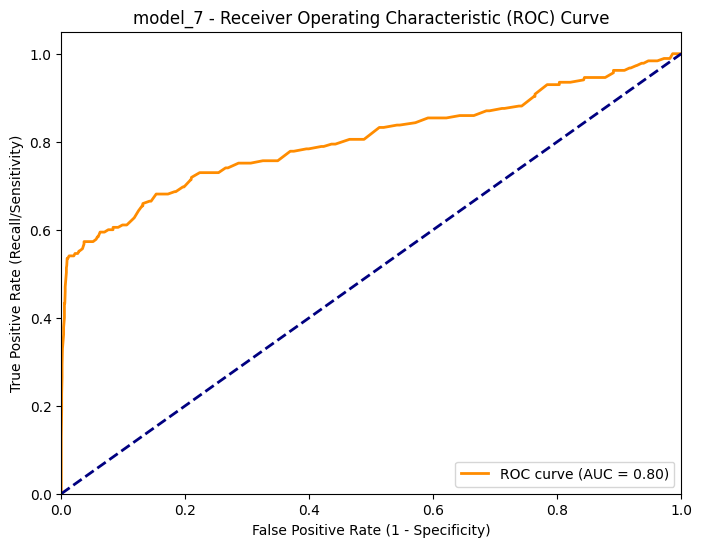

PR-AUC Score: 0.6360


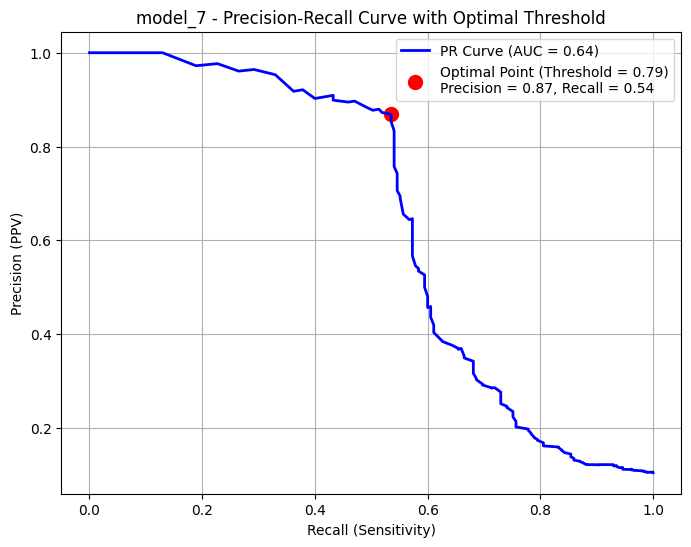


Classification Report at Optimal Threshold (0.79):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.87      0.54      0.66       185

    accuracy                           0.94      1766
   macro avg       0.91      0.76      0.82      1766
weighted avg       0.94      0.94      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1566   15]
 [  86   99]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9905


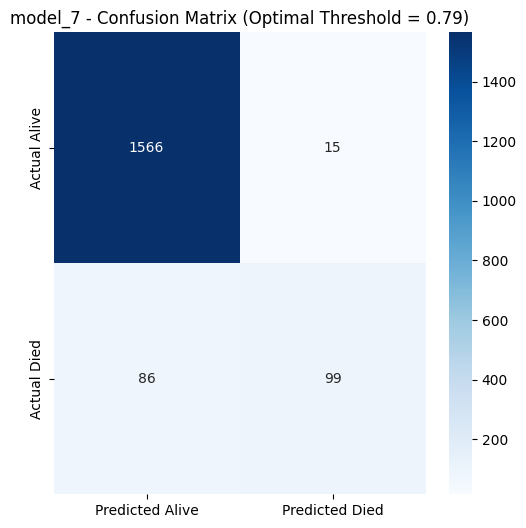

In [ ]:
evaluate_model_performance(y_test, y_us_pred1, y_us_proba1, model_name="model_7")

## UnderSampler + RandomizedSearchCV (RS)

**Training**

In [ ]:
param_dist = {
    'randomundersampler__sampling_strategy': uniform(0.1, 0.9),
    'randomforestclassifier__n_estimators': randint(150, 500),
    'randomforestclassifier__max_depth': [None] + list(np.arange(10, 31, 5)),
    'randomforestclassifier__min_samples_split': randint(5, 30),
    'randomforestclassifier__min_samples_leaf': randint(2, 15),
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [ ]:
# Configure RandomizedSearch
rf_us_rs = RandomizedSearchCV(
    estimator=rf_us,
    param_distributions=param_dist,
    n_iter=200,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=123,
    verbose=1
)

In [ ]:

rf_us_rs.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 514, in fit
    Xt, yt = self._fit(X, y, routed_param

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('randomundersampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=123))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'randomforestclassifier__class_weight': [None,
                                                                                 'balanced',
                                                                                 'balan...
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bed3c28d730>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bed3d2b3440>,
                                        'randomundersampler__sampling_strategy': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bed3d261dc0>},
                   random_state=123, scoring='f1', verbose=1)

In [ ]:

print("Best parameters found: ", rf_us_rs.best_params_)
print("Best F1 score: ", rf_us_rs.best_score_)

Best parameters found:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': np.int64(30), 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 440, 'randomundersampler__sampling_strategy': np.float64(0.25702584517396376)}
Best F1 score:  0.6751339540926863


In [ ]:
best_rf_us_rs = rf_us_rs.best_estimator_
best_rf_us_rs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=123,
                                    sampling_strategy=np.float64(0.25702584517396376))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=np.int64(30),
                                        max_features='log2', min_samples_leaf=4,
                                        min_samples_split=8, n_estimators=440,
                                        n_jobs=-1, random_state=123))])

**Prediction**

In [ ]:

y_us_pred2 = best_rf_us_rs.predict(X_test)
y_us_proba2 = best_rf_us_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_8 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.99      0.97      1581
    Died (1)       0.86      0.53      0.66       185

    accuracy                           0.94      1766
   macro avg       0.90      0.76      0.81      1766
weighted avg       0.94      0.94      0.94      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9899


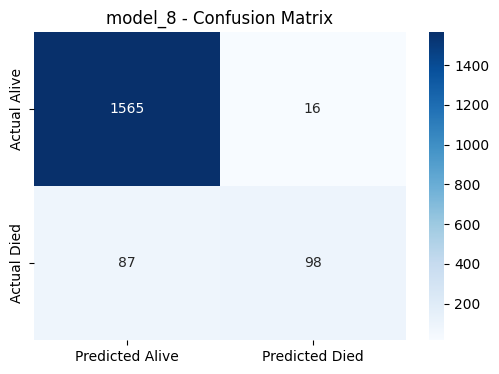


ROC-AUC Score: 0.7885


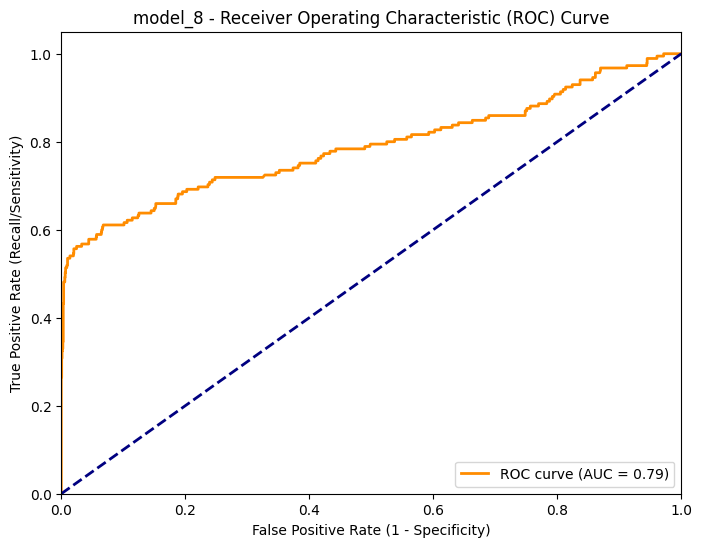

PR-AUC Score: 0.6385


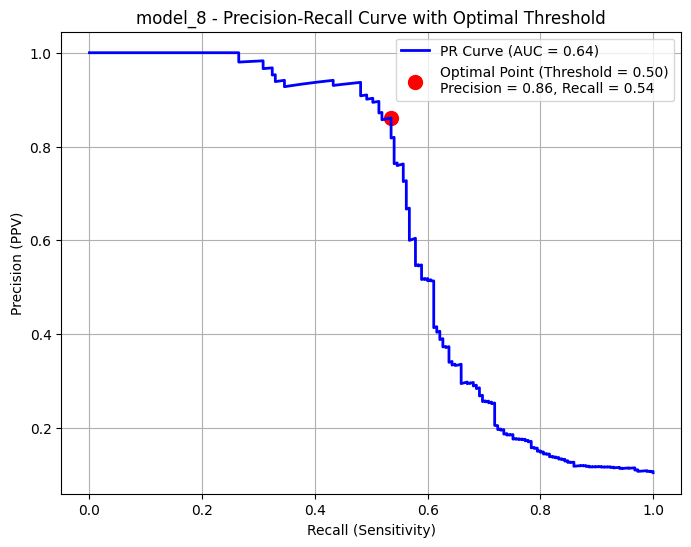


Classification Report at Optimal Threshold (0.50):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.86      0.54      0.66       185

    accuracy                           0.94      1766
   macro avg       0.90      0.76      0.81      1766
weighted avg       0.94      0.94      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1565   16]
 [  86   99]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9899


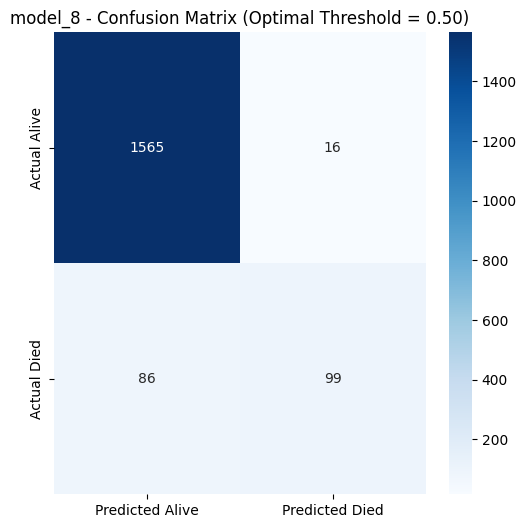

In [ ]:
evaluate_model_performance(y_test, y_us_pred2, y_us_proba2, model_name="model_8")

## UnderSampler + GridSearchCV (GS)

**Training**

In [ ]:
param_grid = {
    'randomundersampler__sampling_strategy': [0.5, 0.7, 0.9],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 15, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10, 20],
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.6, 0.8],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [ ]:

rf_us_gs = GridSearchCV(
    estimator=rf_us,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:
rf_us_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


In [ ]:

print("Best parameters found: ", rf_us_gs.best_params_)
print("Best F1 score: ", rf_us_gs.best_score_)

In [ ]:
best_rf_us_gs = rf_us_gs.best_estimator_
best_rf_us_gs.fit(X_train, y_train)

**Prediction**

In [ ]:

y_us_pred3 = best_rf_us_gs.predict(X_test)
y_us_proba3 = best_rf_us_gs.predict_proba(X_test)[:, 1]

**Evaluation**

In [ ]:
evaluate_model_performance(y_test, y_us_pred3, y_us_proba3, model_name="model_9")

# Train the model after Balancing using HYBRID RESAMPLING

##Hybrid Only

**Training**

In [21]:

rf_hy = make_pipeline(
    SMOTE(random_state=123),
    RandomUnderSampler(random_state=123),
    model_1
)

In [22]:

rf_hy.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('randomundersampler', RandomUnderSampler(random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=123))])

**Prediction**

In [23]:

y_hy_pred1= rf_hy.predict(X_test)
y_hy_proba1 = rf_hy.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_10 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.93      0.94      1581
    Died (1)       0.49      0.53      0.51       185

    accuracy                           0.89      1766
   macro avg       0.71      0.73      0.72      1766
weighted avg       0.90      0.89      0.89      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9342


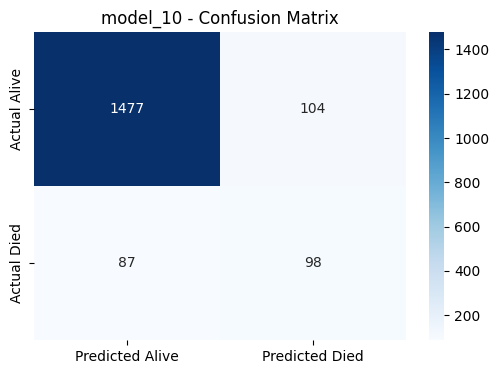


ROC-AUC Score: 0.7813


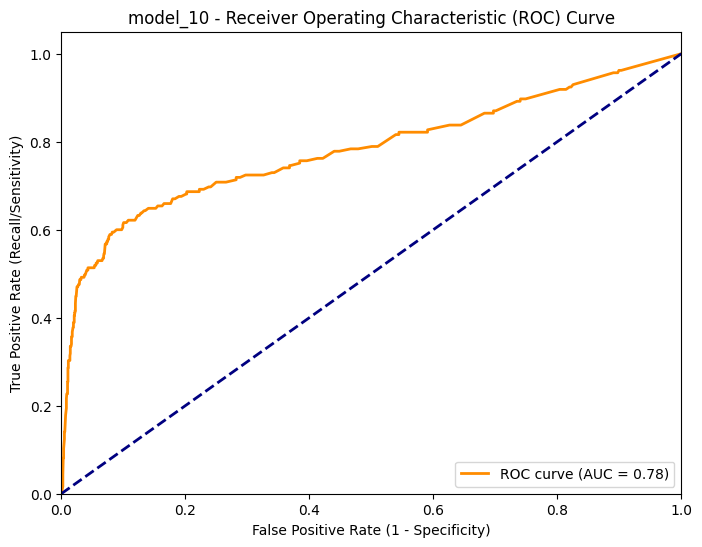

PR-AUC Score: 0.4827


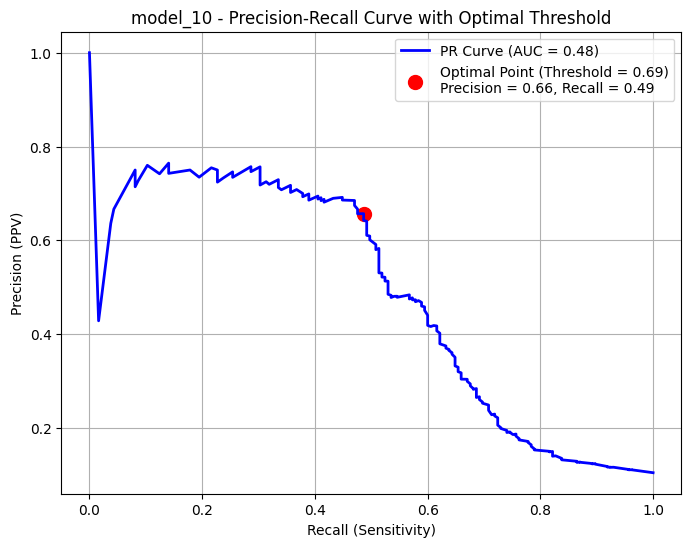


Classification Report at Optimal Threshold (0.69):
              precision    recall  f1-score   support

       Alive       0.94      0.97      0.96      1581
        Died       0.66      0.49      0.56       185

    accuracy                           0.92      1766
   macro avg       0.80      0.73      0.76      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1534   47]
 [  95   90]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9703


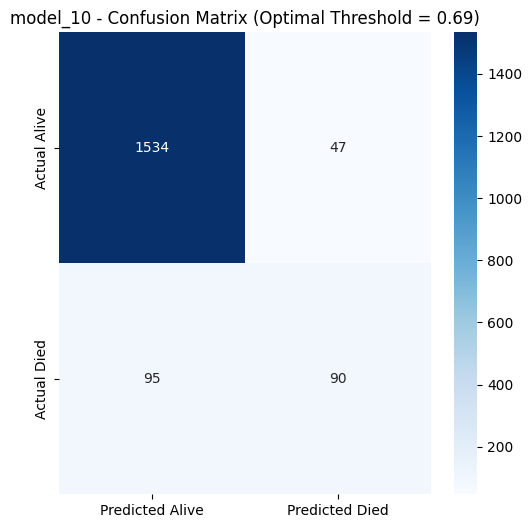

In [26]:
evaluate_model_performance(y_test, y_hy_pred1, y_hy_proba1, model_name="model_10")

## Hybrid + RS

**Training**

In [30]:
param_dist = {
    'randomforestclassifier__n_estimators': np.arange(100, 1001, 100),
    'randomforestclassifier__max_depth': [None] + list(np.arange(5, 51, 5)),
    'randomforestclassifier__min_samples_split': np.arange(2, 21, 2),
    'randomforestclassifier__min_samples_leaf': np.arange(1, 11),
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'randomforestclassifier__max_samples': [None, 0.7, 0.8, 0.9],
    'smote__sampling_strategy': np.linspace(0.1, 1.0, 10),
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample', None]
}

In [31]:

rf_hy_rs = RandomizedSearchCV(
    estimator=rf_hy,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_scorer,
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=123
)

In [32]:
rf_hy_rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 514, in fit
    Xt, yt = self._fit(X, y, routed_par

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                             ('randomundersampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__clas...
                                        'randomforestclassifier__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'randomforestclassifier__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'smote__sampling_strategy': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=123,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=2)

In [33]:

print("\nBest Params:", rf_hy_rs.best_params_)
print("Best F1 Score (CV):", rf_hy_rs.best_score_)


Best Params: {'smote__sampling_strategy': np.float64(0.7000000000000001), 'randomforestclassifier__n_estimators': np.int64(800), 'randomforestclassifier__min_samples_split': np.int64(8), 'randomforestclassifier__min_samples_leaf': np.int64(2), 'randomforestclassifier__max_samples': 0.8, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': np.int64(10), 'randomforestclassifier__class_weight': 'balanced'}
Best F1 Score (CV): 0.5853166634128385


In [34]:
best_rf_hy_rs = rf_hy_rs.best_estimator_
best_rf_hy_rs.fit(X_train, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote',
                 SMOTE(random_state=123,
                       sampling_strategy=np.float64(0.7000000000000001))),
                ('randomundersampler', RandomUnderSampler(random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=np.int64(10),
                                        max_features='log2', max_samples=0.8,
                                        min_samples_leaf=np.int64(2),
                                        min_samples_split=np.int64(8),
                                        n_estimators=np.int64(800), n_jobs=-1,
                                        random_state=123))])

**Prediction**

In [35]:

y_hy_pred2 = best_rf_hy_rs.predict(X_test)
y_hy_proba2 = best_rf_hy_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_11 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.94      0.95      1581
    Died (1)       0.54      0.58      0.56       185

    accuracy                           0.90      1766
   macro avg       0.74      0.76      0.75      1766
weighted avg       0.91      0.90      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9412


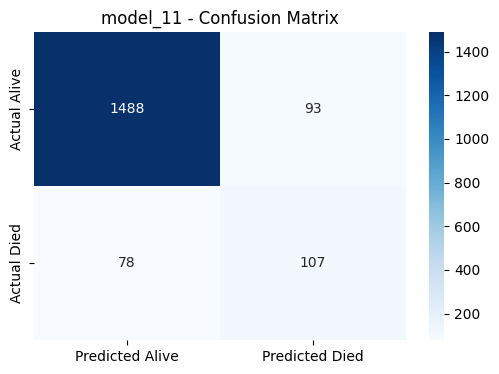


ROC-AUC Score: 0.8045


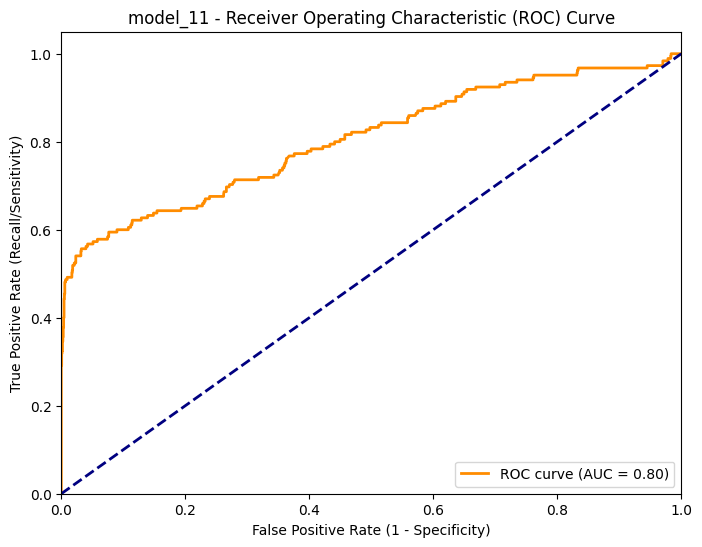

PR-AUC Score: 0.6256


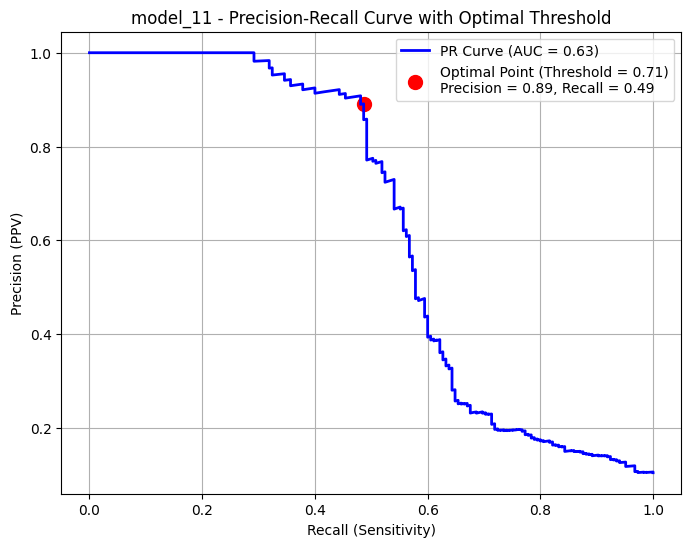


Classification Report at Optimal Threshold (0.71):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.97      1581
        Died       0.89      0.49      0.63       185

    accuracy                           0.94      1766
   macro avg       0.92      0.74      0.80      1766
weighted avg       0.94      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1570   11]
 [  95   90]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9930


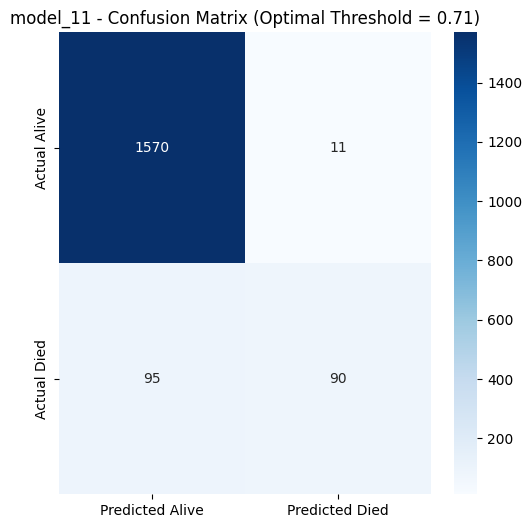

In [36]:
evaluate_model_performance(y_test, y_hy_pred2, y_hy_proba2, model_name="model_11")

##Hybrid + GS

**Training**

In [40]:

param_grid = {
    'randomforestclassifier__n_estimators': [200, 300],
    'randomforestclassifier__max_depth': [15, None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__max_features': ['sqrt'],
}

In [41]:


rf_hy_gs = HalvingGridSearchCV(
    estimator=rf_hy,
    param_grid=param_grid,
    factor=2,
    cv=cv,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    aggressive_elimination=True
)

In [42]:
rf_hy_gs.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 882
max_resources_: 7063
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 882
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------
iter: 1
n_candidates: 4
n_resources: 1764
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 3528
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 7056
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


HalvingGridSearchCV(aggressive_elimination=True,
                    cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                    estimator=Pipeline(steps=[('smote',
                                               SMOTE(random_state=123)),
                                              ('randomundersampler',
                                               RandomUnderSampler(random_state=123)),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=123))]),
                    factor=2, n_jobs=-1,
                    param_grid={'randomforestclassifier__max_depth': [15, None],
                                'randomforestclassifier__max_features': ['sqrt'],
                                'randomforestclassifier__min_samples_split': [2,
                                                                              5],
                                'randomforestclassifier__n_estimators': [200,
                                                                         300]},
                    scoring='f1', verbose=2)

In [43]:

print("\nBest Params:", rf_hy_gs.best_params_)
print("Best F1 Score (CV):", rf_hy_gs.best_score_)


Best Params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 300}
Best F1 Score (CV): 0.5817818619465394


In [44]:
best_rf_hy_gs = rf_hy_gs.best_estimator_
best_rf_hy_gs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('randomundersampler', RandomUnderSampler(random_state=123)),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=300,
                                        n_jobs=-1, random_state=123))])

**Prediction**

In [45]:

y_hy_pred3 = best_rf_hy_gs.predict(X_test)
y_hy_proba3 = best_rf_hy_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_12 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.94      0.94      1581
    Died (1)       0.52      0.55      0.53       185

    accuracy                           0.90      1766
   macro avg       0.73      0.74      0.74      1766
weighted avg       0.90      0.90      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9412


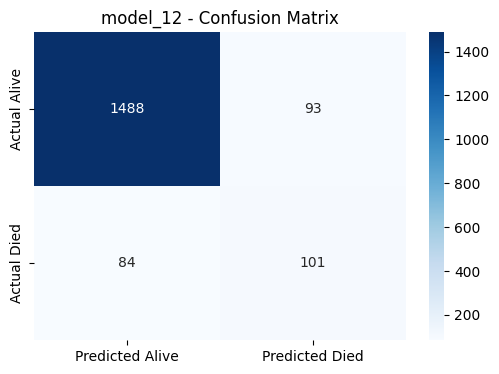


ROC-AUC Score: 0.7812


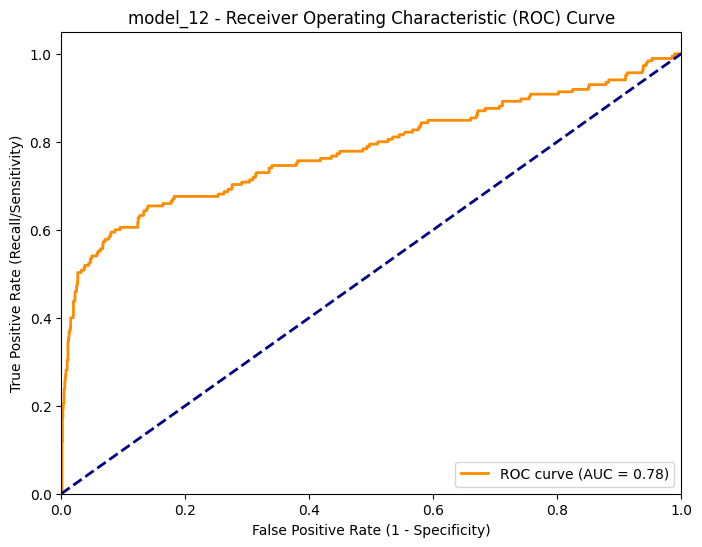

PR-AUC Score: 0.5241


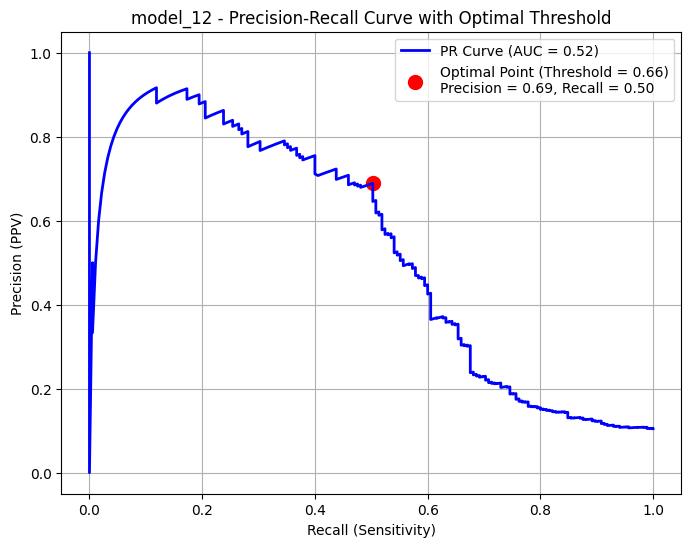


Classification Report at Optimal Threshold (0.66):
              precision    recall  f1-score   support

       Alive       0.94      0.97      0.96      1581
        Died       0.69      0.50      0.58       185

    accuracy                           0.92      1766
   macro avg       0.82      0.74      0.77      1766
weighted avg       0.92      0.92      0.92      1766

Confusion Matrix at Optimal Threshold:
[[1539   42]
 [  92   93]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9734


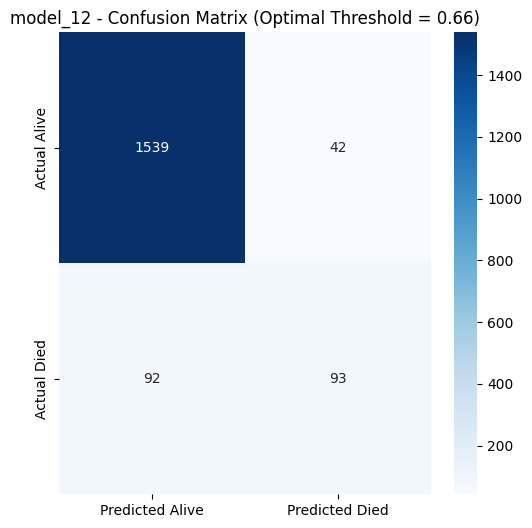

In [46]:
evaluate_model_performance(y_test, y_hy_pred3, y_hy_proba3, model_name="model_12")

#Overfitting Assessment

Compute training and test accuracy to check for overfitting

High training accuracy + low test accuracy = overfitting.

In [ ]:
# Predict on training data
y_o_train_pred = best_rf_rs.predict(X_train)
train_accuracy = accuracy_score(y_train, y_o_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on test data
y_o_test_pred = best_rf_rs.predict(X_test)
test_accuracy = accuracy_score(y_test, y_o_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare: If train >> test, potential overfitting
if train_accuracy - test_accuracy > 0.05:  # Arbitrary threshold; adjust based on domain
    print("Warning: Model may be overfitting (large gap between train and test accuracy).")
else:
    print("Model appears well-generalized.")

Training Accuracy: 0.9548
Test Accuracy: 0.9388
Model appears well-generalized.
